In [ ]:
!git clone https://github.com/referreira-wisc/digag2022.git

In [ ]:
import os
os.chdir('digag2022/LabAccelerometer')

### Imports

In [96]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

### Load excel file

In [30]:
data = pd.read_excel('Accelerometer_HW03.xlsx')
data

,time_seconds,AccX,AccY,AccZ,Label,Person
0,67,0.082596,4.078347,9.000614,walking,user1
1,134,0.114917,4.196855,8.622347,walking,user1
2,201,-0.062247,4.327333,8.760008,walking,user1
3,268,-0.113720,4.274663,8.646288,walking,user1
4,335,-0.047882,4.244737,8.607983,walking,user1
...,...,...,...,...,...,...
2752,21105,-0.381480,6.012052,7.449938,jumping,user6
2753,21172,-0.677920,5.871917,7.687091,jumping,user6
2754,21239,-0.470712,6.310888,7.699667,jumping,user6
2755,21306,-1.101321,6.410900,7.546356,jumping,user6


### Create variables and labels numpy arrays

In [75]:
X = np.array(data[['AccX', 'AccY', 'AccZ']])
y = np.array(data['Label'])
print(X.shape)
print(y.shape)
print(X)
print(y)

(2757, 3)
(2757,)
[[ 0.08259641  4.07834721  9.00061417]
 [ 0.11491674  4.19685507  8.62234688]
 [-0.06224657  4.32733345  8.76000786]
 ...
 [-0.47071153  6.31088829  7.69966698]
 [-1.10132122  6.41089964  7.5463562 ]
 [-1.52412319  6.33783722  7.4888649 ]]
['walking' 'walking' 'walking' ... 'jumping' 'jumping' 'jumping']


### Train Random Forest and perform leave-one-person-out cross-validation (AccX, AccY, and AccZ as features)

In [32]:
person_list = data['Person'].unique()
accuracies = []
for person in person_list:
  train_ids = np.array(data['Person'] != person)
  test_ids = np.array(data['Person'] == person)
  train_X = X[train_ids]
  train_y = y[train_ids]
  test_X = X[test_ids]
  test_y = y[test_ids]
  # Create Random Forest estimator with default hyperparameters
  rf = RandomForestClassifier()
  # Train Random Forest estimator with training set
  rf.fit(train_X, train_y)
  # Predict test set using trained Random Forest
  ypred = rf.predict(test_X)
  ytrue = test_y
  accuracy = np.mean(ypred == ytrue)
  accuracies.append(accuracy)
  print(f'Accuracy on {person}: {accuracy:.3f}')
print(f'Mean accuracy: {np.mean(accuracies):.3f}')

Accuracy on user1: 0.532
Accuracy on user2: 0.459
Accuracy on user3: 0.416
Accuracy on user4: 0.513
Accuracy on user5: 0.458
Accuracy on user6: 0.492
Mean accuracy: 0.478


### Group AccX, AccY, and AccZ values into windows (windows of size 10 in this case)

In [90]:
def prepare_data(window_size):
  X_all = []
  y_all = []
  person_all = []
  for person in person_list:
    X_person = np.array(data[data['Person']==person][['AccX', 'AccY', 'AccZ']])
    y_person = np.array(data[data['Person']==person]['Label'])
    for i in range(len(X_person) - window_size + 1):
      xi = []
      yi = []
      for w in range(window_size):
        xi.append(X_person[i + w])
        yi.append(y_person[i + w])
      xi = np.array(xi).flatten()
      yi = np.array(yi)
      unique, pos = np.unique(yi, return_inverse=True)
      counts = np.bincount(pos)
      maxpos = np.argmax(counts)
      yi = unique[maxpos]
      X_all.append(xi)
      y_all.append(yi)
      person_all.append(person)
  X_all = np.array(X_all)
  y_all = np.array(y_all)
  person_all = np.array(person_all)
  print(f'X_all shape: {X_all.shape}')
  print(f'y_all shape: {y_all.shape}')
  print(f'person_all shape: {person_all.shape}')
  return X_all, y_all, person_all

window_size = 10
X_all, y_all, person_all = prepare_data(window_size=window_size)

X_all shape: (2703, 30)
y_all shape: (2703,)
person_all shape: (2703,)


### Train Random Forest and perform leave-one-person-out cross-validation (windows of AccX, AccY, and AccZ as features)

In [94]:
def train_random_forest(X_all, y_all, person_all):
  person_list = data['Person'].unique()
  accuracies = []
  for person in person_list:
    train_ids = person_all != person
    test_ids = person_all == person
    train_X = X_all[train_ids]
    train_y = y_all[train_ids]
    test_X = X_all[test_ids]
    test_y = y_all[test_ids]
    # Create Random Forest estimator with default hyperparameters
    rf = RandomForestClassifier()
    # Train Random Forest estimator with training set
    rf.fit(train_X, train_y)
    # Predict test set using trained Random Forest
    ypred = rf.predict(test_X)
    ytrue = test_y
    accuracy = np.mean(ypred == ytrue)
    accuracies.append(accuracy)
    print(f'Accuracy on {person}: {accuracy:.3f}')
  print(f'Mean accuracy: {np.mean(accuracies):.3f}')
  return np.mean(accuracies)

print(f'Window size: {window_size}')
_ = train_random_forest(X_all, y_all, person_all)

Window size: 40
Accuracy on user1: 0.554
Accuracy on user2: 0.499
Accuracy on user3: 0.576
Accuracy on user4: 0.751
Accuracy on user5: 0.717
Accuracy on user6: 0.425
Mean accuracy: 0.587


### Try a few different window sizes

In [97]:
accuracies_per_window_size = []
window_sizes = [1, 3, 5, 10, 20, 50, 100, 200]
for window_size in window_sizes:
  print(f'Window size: {window_size}')
  X_all, y_all, person_all = prepare_data(window_size=window_size)
  mean_acc = train_random_forest(X_all, y_all, person_all)
  accuracies_per_window_size.append(mean_acc)
  print('\n')

Window size: 3
X_all shape: (2745, 9)
y_all shape: (2745,)
person_all shape: (2745,)
Accuracy on user1: 0.587
Accuracy on user2: 0.466
Accuracy on user3: 0.505
Accuracy on user4: 0.648
Accuracy on user5: 0.504
Accuracy on user6: 0.473
Mean accuracy: 0.531


Window size: 5
X_all shape: (2733, 15)
y_all shape: (2733,)
person_all shape: (2733,)
Accuracy on user1: 0.583
Accuracy on user2: 0.504
Accuracy on user3: 0.547
Accuracy on user4: 0.665
Accuracy on user5: 0.535
Accuracy on user6: 0.483
Mean accuracy: 0.553


Window size: 10
X_all shape: (2703, 30)
y_all shape: (2703,)
person_all shape: (2703,)
Accuracy on user1: 0.602
Accuracy on user2: 0.501
Accuracy on user3: 0.506
Accuracy on user4: 0.685
Accuracy on user5: 0.557
Accuracy on user6: 0.535
Mean accuracy: 0.564


Window size: 20
X_all shape: (2643, 60)
y_all shape: (2643,)
person_all shape: (2643,)
Accuracy on user1: 0.549
Accuracy on user2: 0.530
Accuracy on user3: 0.519
Accuracy on user4: 0.722
Accuracy on user5: 0.670
Accuracy on

### Plot mean accuracy by window size

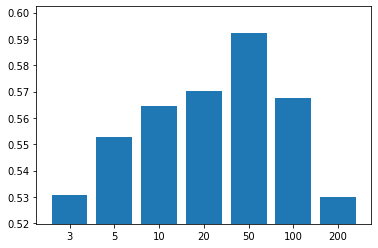

In [105]:
plt.bar(np.array(window_sizes, dtype=str), accuracies_per_window_size)
plt.ylim([min(accuracies_per_window_size) - 0.01, max(accuracies_per_window_size) + 0.01])
plt.show()